<a href="https://colab.research.google.com/github/depresssed-kid/ScoobyDoo-image-classification/blob/main/scoobydoo_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import math
import cv2
from random import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as Data
from torchvision import models
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_path = '/content/drive/MyDrive/kaggle/dataset'
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)

img_size = (224, 224, 3)

print('classes: ', class_names)

classes:  ['Daphne', 'Fred', 'Scooby', 'Shaggy', 'Velma']


In [4]:
labels = []
images = []

print('images:\n')
for cl in class_names:
    print(cl, end=' -> ')
    for img in os.listdir(data_path +'/'+ cl):
        label = np.zeros(num_classes)
        label[class_names.index(cl)] = 1
        labels.append(label)
        image = cv2.imread(data_path + "/" + cl + '/' + img, cv2.IMREAD_COLOR)
        image = cv2.resize(image,(224,224))[:, :, ::-1]
        image = np.asarray(image)
        images.append(image)
    print('done')


labels = np.asarray(labels)
images = np.asarray(images)

print(f'\n\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

images:

Daphne -> done
Fred -> done
Scooby -> done
Shaggy -> done
Velma -> done


labels shape: (221, 5)
images shape: (221, 224, 224, 3)


In [5]:

class DataSet():

  def __init__(self,images,labels,transform = None):
    self.image = images
    self.label = labels
    self.transform = transform

  def __getitem__(self, index):
      image = self.image[index]
      if self.transform:
          image = self.transform(self.image[index])
      return image, self.label[index]


  def __len__(self):
    return len(self.image)




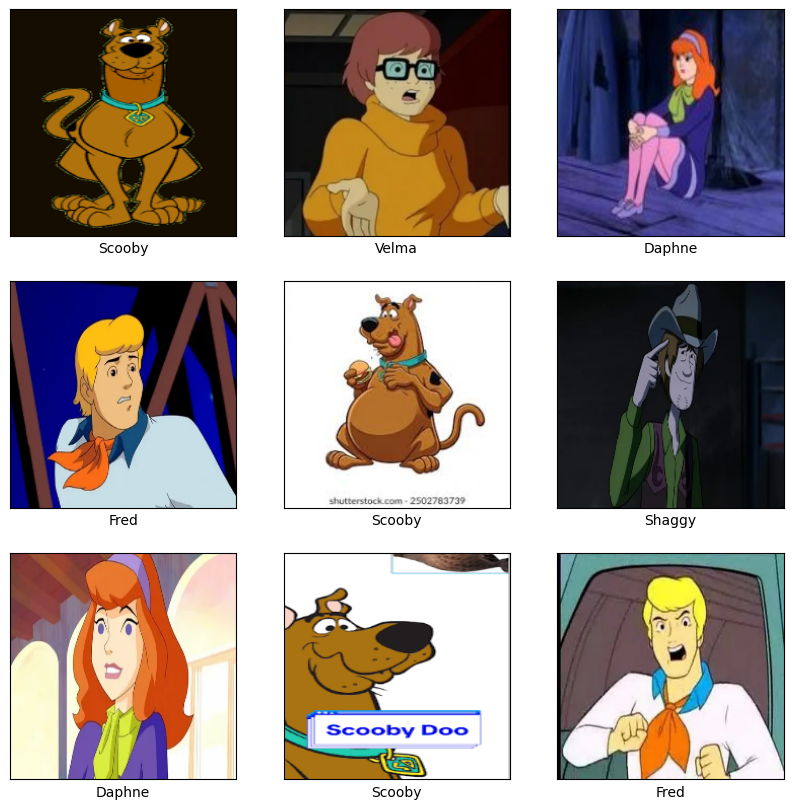

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for x in range(3):
    for y in range(3):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])

        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])

plt.show()

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)


        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 5):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [36]:
num_epochs = 100
batch_size = 32
learning_rate = 0.0003
num_classes = 5
loss_threshold = 0.001
acc_treshold = 90

In [10]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

y_train = torch.from_numpy(y_train).long()
y_val = torch.from_numpy(y_val).long()

if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = torch.argmax(y_train, dim=1)
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val = torch.argmax(y_val, dim=1)


DATA_MEANS = (X_train / 255.0).mean(axis=(0, 1, 2))
DATA_STD = (X_train / 255.0).std(axis=(0, 1, 2))
print("Data mean", DATA_MEANS)
print("Data std", DATA_STD)

Data mean [0.49791932 0.46327694 0.41514332]
Data std [0.35302223 0.32898843 0.33942471]


In [11]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEANS, std=DATA_STD)
])

In [12]:
dataset_train = DataSet(X_train, y_train,transform)
dataset_test = DataSet(X_val, y_val,transform)


train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)


In [38]:

resnet = ResNet(ResidualBlock, [6, 6, 6, 6], num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate)


total_step = len(train_loader)
total_step_test = len(test_loader)

test_losses = []
train_losses = []
test_accuracies = []
train_accuracies = []
for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    train_losses.append(running_loss / total_step)

    #validating model
    resnet.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        running_loss_test = 0
        for (images, labels) in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet(images)
            ver, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss_test = criterion(outputs, labels)
            running_loss_test += loss.item()
        test_losses.append(running_loss_test/total_step_test)
        accuracy_test = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy_test:.2f}% ', end='')
        test_accuracies.append(accuracy_test)

        train_correct = 0
        train_total = 0
        for (images, labels) in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet(images)
            ver, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        accuracy_train = 100 * train_correct / train_total
        print(f', train : {accuracy_train:.2f}%')
        train_accuracies.append(accuracy_train)

    if running_loss_test/total_step_test < loss_threshold or accuracy_test > acc_treshold:
        print('final loss: ',running_loss_test/total_step_test,' accuracy on test:', accuracy_test)
        break






Epoch [1/100], Test Accuracy: 15.56% , train : 24.43%
Epoch [2/100], Test Accuracy: 15.56% , train : 24.43%
Epoch [3/100], Test Accuracy: 17.78% , train : 13.07%
Epoch [4/100], Test Accuracy: 22.22% , train : 27.27%
Epoch [5/100], Test Accuracy: 22.22% , train : 28.41%
Epoch [6/100], Test Accuracy: 28.89% , train : 49.43%
Epoch [7/100], Test Accuracy: 40.00% , train : 80.11%
Epoch [8/100], Test Accuracy: 55.56% , train : 62.50%
Epoch [9/100], Test Accuracy: 40.00% , train : 66.48%
Epoch [10/100], Test Accuracy: 40.00% , train : 51.70%
Epoch [11/100], Test Accuracy: 62.22% , train : 94.89%
Epoch [12/100], Test Accuracy: 37.78% , train : 74.43%
Epoch [13/100], Test Accuracy: 60.00% , train : 92.05%
Epoch [14/100], Test Accuracy: 60.00% , train : 83.52%
Epoch [15/100], Test Accuracy: 64.44% , train : 97.73%
Epoch [16/100], Test Accuracy: 46.67% , train : 92.05%
Epoch [17/100], Test Accuracy: 57.78% , train : 98.86%
Epoch [18/100], Test Accuracy: 68.89% , train : 97.73%
Epoch [19/100], Tes

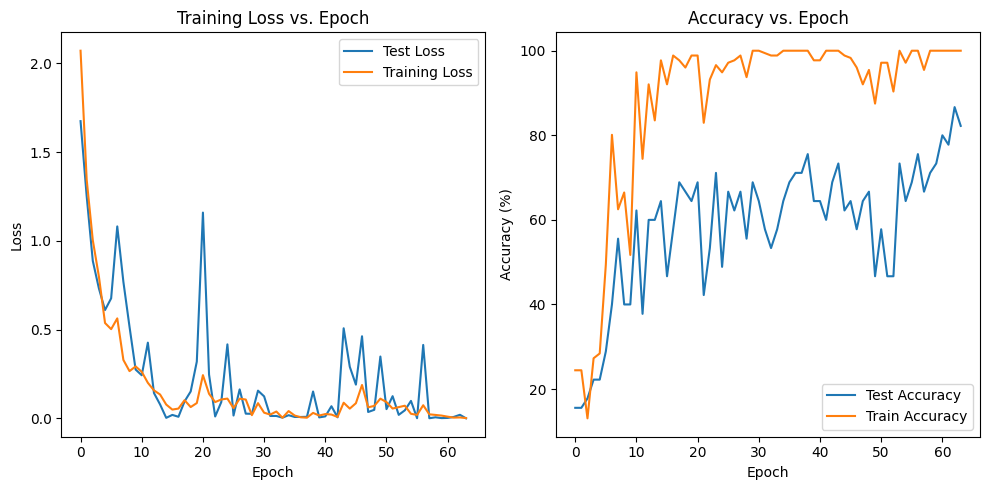

In [41]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()